# **Libraries We'll Be Using**

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.utils import np_utils


from keras.optimizers import RMSprop, Adam
from keras.metrics import categorical_accuracy


from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

# **Loading Preprocessed Dataset**

**Loading the Data**

In [2]:
# open our uploaded file
svhn_data = h5py.File('SVHN_Preprocessed_Multi.h5', 'r')

# load the training, testing and validation set
X_train = svhn_data['X_train'][:]
y_train = svhn_data['y_train'][:]
X_test = svhn_data['X_test'][:]
y_test = svhn_data['y_test'][:]
X_val = svhn_data['X_val'][:]
y_val = svhn_data['y_val'][:]

# close the file
svhn_data.close()


# check that our datasets are correct
print('Training X Shape: ', X_train.shape)
print('Training Y Shape: ', y_train.shape)
print('Testing X Shape: ', X_test.shape)
print('Testing Y Shape: ', y_test.shape)
print('Validation X Shape: ', X_val.shape)
print('Validation Y Shape: ', y_val.shape)

Training X Shape:  (26720, 32, 32, 1)
Training Y Shape:  (26720, 5)
Testing X Shape:  (13068, 32, 32, 1)
Testing Y Shape:  (13068, 5)
Validation X Shape:  (6681, 32, 32, 1)
Validation Y Shape:  (6681, 5)


**Display Some Training Images**

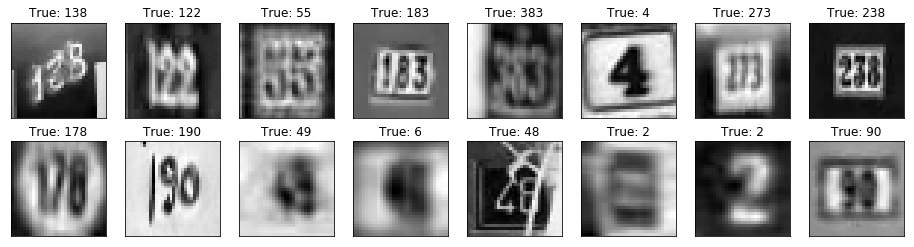

In [3]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # plot n rows, m columns
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # randomly select images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # get the image numbers
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
        
        
        # display images with true label
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# plot some images from the training set
plot_images(X_train, 2, 8, y_train)

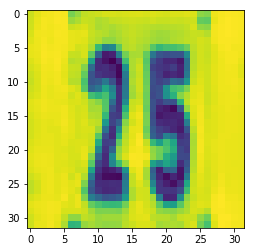

In [4]:
plt.figure()
plt.imshow(X_train[2,:,:,0])

# **Prepare Train/Test/Validation Labels for Multi-Digit CNN Model**

In [5]:
def create_output_labels(labels):

  # 11 possible classes
  # classes for digits 0-9 and a class for no digit 
  classes = 11
  
  # output arrays
  dig1 = np.ndarray(shape=(len(labels), classes))
  dig2 = np.ndarray(shape=(len(labels), classes))
  dig3 = np.ndarray(shape=(len(labels), classes))
  dig4 = np.ndarray(shape=(len(labels), classes))
  dig5 = np.ndarray(shape=(len(labels), classes))

  # create one hot encoded labels
  for index,label in enumerate(labels):

      dig1[index,:] = np_utils.to_categorical(label[0], classes)
      dig2[index,:] = np_utils.to_categorical(label[1], classes)
      dig3[index,:] = np_utils.to_categorical(label[2], classes)
      dig4[index,:] = np_utils.to_categorical(label[3], classes)
      dig5[index,:] = np_utils.to_categorical(label[4], classes)

  return [dig1, dig2, dig3, dig4, dig5]
  

  
# create the train/test/val output arrays
train_labels = create_output_labels(y_train)
test_labels = create_output_labels(y_test)
val_labels = create_output_labels(y_val)


# check that the output shape is fine
print(np.shape(train_labels[0]))

(26720, 11)


# **Create a CNN Model**

**Multi-Output Model**

In [6]:
def cnn_model_multi():

  weight_decay = 1e-4
  classes = 11


  # LAYER 1
  model_input = Input(shape=X_train.shape[1:])

  M = Conv2D(32, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(model_input)
  M = BatchNormalization()(M)
  M = Conv2D(32, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(M)
  M = BatchNormalization()(M)
  M = MaxPooling2D(pool_size=(2,2))(M)
  M = Dropout(0.2)(M)


  # LAYER 2
  M = Conv2D(64, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(M)
  M = BatchNormalization()(M)
  M = Conv2D(64, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(M)
  M = BatchNormalization()(M)
  M = MaxPooling2D(pool_size=(2,2))(M)
  M = Dropout(0.3)(M)


  # LAYER 3
  M = Conv2D(128, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(M)
  M = BatchNormalization()(M)
  M = Conv2D(128, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(M)
  M = BatchNormalization()(M)
  M = MaxPooling2D(pool_size=(2,2))(M)
  M = Dropout(0.4)(M)


  # OUTPUT
  Mout = Flatten()(M)

  dig1 = Dense(classes, activation='softmax', name = 'dig1')(Mout)
  dig2 = Dense(classes, activation='softmax', name = 'dig2')(Mout)
  dig3 = Dense(classes, activation='softmax', name = 'dig3')(Mout)
  dig4 = Dense(classes, activation='softmax', name = 'dig4')(Mout)
  dig5 = Dense(classes, activation='softmax', name = 'dig5')(Mout)

  out = [dig1, dig2, dig3, dig4, dig5]
  
  model = Model(inputs=model_input, outputs=out)
  return model

TEMP MODEL 2

In [7]:
def cnn_model_multi2():
  
  classes = 11
  model_input = Input(shape=X_train.shape[1:])
  
  
  # layer 1
  x = Conv2D(filters=48, kernel_size=5, padding="same")(model_input)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 2
  x = Conv2D(filters=64, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=1, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 3
  x = Conv2D(filters=128, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 4
  x = Conv2D(filters=160, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=1, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 5
  x = Conv2D(filters=192, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 6
  x = Conv2D(filters=192, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=1, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 7
  x = Conv2D(filters=192, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 8
  x = Conv2D(filters=192, kernel_size=5, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2, strides=1, padding="same")(x)
  x = Dropout(0.25)(x)

  # layer 9
  x = Flatten()(x)
  x = Dense(units=3072)(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  # layer 10
  x = Dense(units=3072)(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)
  
  # output
  dig1 = Dense(classes, activation='softmax', name = 'dig1')(x)
  dig2 = Dense(classes, activation='softmax', name = 'dig2')(x)
  dig3 = Dense(classes, activation='softmax', name = 'dig3')(x)
  dig4 = Dense(classes, activation='softmax', name = 'dig4')(x)
  dig5 = Dense(classes, activation='softmax', name = 'dig5')(x)

  out = [dig1, dig2, dig3, dig4, dig5]
  model = Model(inputs=model_input, outputs=out)
  return model

# **Fit the Model and Display Accuracy**

**Compile, train, and save our CNN model**

In [8]:
# create and compile our model
model = cnn_model_multi()
model.compile(loss='categorical_crossentropy', 
              optimizer = RMSprop(lr=0.001, decay=1e-6), 
              metrics=["accuracy"])

# parameters for model fitting
batch_size = 128
epochs = 100

# train the model
model.fit(x=X_train, y=train_labels,
          validation_data=(X_val, val_labels),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

# save the model
model.save("SVHN_model_multi.h5")

Epoch 1/100
209/209 [==============================] - 197s 942ms/step - loss: 5.9365 - dig1_loss: 2.0209 - dig2_loss: 2.3193 - dig3_loss: 1.2530 - dig4_loss: 0.2811 - dig5_loss: 0.0242 - dig1_accuracy: 0.4308 - dig2_accuracy: 0.3439 - dig3_accuracy: 0.6843 - dig4_accuracy: 0.9479 - dig5_accuracy: 0.9950 - val_loss: 5.5887 - val_dig1_loss: 1.6906 - val_dig2_loss: 2.3782 - val_dig3_loss: 1.1654 - val_dig4_loss: 0.3108 - val_dig5_loss: 0.0030 - val_dig1_accuracy: 0.5598 - val_dig2_accuracy: 0.4570 - val_dig3_accuracy: 0.7331 - val_dig4_accuracy: 0.9530 - val_dig5_accuracy: 0.9997
Epoch 2/100
209/209 [==============================] - 159s 761ms/step - loss: 3.2399 - dig1_loss: 1.0074 - dig2_loss: 1.2871 - dig3_loss: 0.7250 - dig4_loss: 0.1731 - dig5_loss: 0.0038 - dig1_accuracy: 0.6916 - dig2_accuracy: 0.5957 - dig3_accuracy: 0.7834 - dig4_accuracy: 0.9589 - dig5_accuracy: 0.9997 - val_loss: 2.5520 - val_dig1_loss: 0.8359 - val_dig2_loss: 0.9641 - val_dig3_loss: 0.5418 - val_dig4_loss: 0

Epoch 15/100
209/209 [==============================] - 135s 648ms/step - loss: 0.9550 - dig1_loss: 0.2655 - dig2_loss: 0.3330 - dig3_loss: 0.2092 - dig4_loss: 0.0418 - dig5_loss: 8.7189e-04 - dig1_accuracy: 0.9159 - dig2_accuracy: 0.8919 - dig3_accuracy: 0.9314 - dig4_accuracy: 0.9865 - dig5_accuracy: 0.9997 - val_loss: 1.2405 - val_dig1_loss: 0.3183 - val_dig2_loss: 0.4235 - val_dig3_loss: 0.3085 - val_dig4_loss: 0.0799 - val_dig5_loss: 0.0038 - val_dig1_accuracy: 0.9065 - val_dig2_accuracy: 0.8804 - val_dig3_accuracy: 0.9145 - val_dig4_accuracy: 0.9793 - val_dig5_accuracy: 0.9997
Epoch 16/100
209/209 [==============================] - 135s 644ms/step - loss: 0.9357 - dig1_loss: 0.2571 - dig2_loss: 0.3277 - dig3_loss: 0.2007 - dig4_loss: 0.0412 - dig5_loss: 6.6275e-04 - dig1_accuracy: 0.9162 - dig2_accuracy: 0.8938 - dig3_accuracy: 0.9343 - dig4_accuracy: 0.9868 - dig5_accuracy: 0.9998 - val_loss: 1.2648 - val_dig1_loss: 0.3186 - val_dig2_loss: 0.4290 - val_dig3_loss: 0.3190 - val_di

Epoch 29/100
209/209 [==============================] - 132s 631ms/step - loss: 0.6927 - dig1_loss: 0.1707 - dig2_loss: 0.2150 - dig3_loss: 0.1318 - dig4_loss: 0.0236 - dig5_loss: 4.5566e-04 - dig1_accuracy: 0.9436 - dig2_accuracy: 0.9271 - dig3_accuracy: 0.9549 - dig4_accuracy: 0.9923 - dig5_accuracy: 0.9999 - val_loss: 1.3178 - val_dig1_loss: 0.3228 - val_dig2_loss: 0.4381 - val_dig3_loss: 0.3224 - val_dig4_loss: 0.0781 - val_dig5_loss: 0.0040 - val_dig1_accuracy: 0.9136 - val_dig2_accuracy: 0.8873 - val_dig3_accuracy: 0.9208 - val_dig4_accuracy: 0.9801 - val_dig5_accuracy: 0.9997
Epoch 30/100
209/209 [==============================] - 133s 636ms/step - loss: 0.6882 - dig1_loss: 0.1717 - dig2_loss: 0.2102 - dig3_loss: 0.1301 - dig4_loss: 0.0218 - dig5_loss: 6.4010e-04 - dig1_accuracy: 0.9407 - dig2_accuracy: 0.9301 - dig3_accuracy: 0.9564 - dig4_accuracy: 0.9929 - dig5_accuracy: 0.9998 - val_loss: 1.3170 - val_dig1_loss: 0.3198 - val_dig2_loss: 0.4289 - val_dig3_loss: 0.3179 - val_di

Epoch 43/100
209/209 [==============================] - 133s 635ms/step - loss: 0.6161 - dig1_loss: 0.1367 - dig2_loss: 0.1714 - dig3_loss: 0.1056 - dig4_loss: 0.0185 - dig5_loss: 1.9348e-04 - dig1_accuracy: 0.9532 - dig2_accuracy: 0.9420 - dig3_accuracy: 0.9650 - dig4_accuracy: 0.9937 - dig5_accuracy: 0.9999 - val_loss: 1.3388 - val_dig1_loss: 0.3167 - val_dig2_loss: 0.4218 - val_dig3_loss: 0.3191 - val_dig4_loss: 0.0909 - val_dig5_loss: 0.0056 - val_dig1_accuracy: 0.9189 - val_dig2_accuracy: 0.8957 - val_dig3_accuracy: 0.9235 - val_dig4_accuracy: 0.9801 - val_dig5_accuracy: 0.9997
Epoch 44/100
209/209 [==============================] - 133s 636ms/step - loss: 0.6084 - dig1_loss: 0.1359 - dig2_loss: 0.1672 - dig3_loss: 0.0997 - dig4_loss: 0.0196 - dig5_loss: 3.3905e-04 - dig1_accuracy: 0.9535 - dig2_accuracy: 0.9433 - dig3_accuracy: 0.9659 - dig4_accuracy: 0.9937 - dig5_accuracy: 0.9999 - val_loss: 1.4182 - val_dig1_loss: 0.3251 - val_dig2_loss: 0.4488 - val_dig3_loss: 0.3486 - val_di

Epoch 57/100
209/209 [==============================] - 134s 643ms/step - loss: 0.5743 - dig1_loss: 0.1162 - dig2_loss: 0.1506 - dig3_loss: 0.0845 - dig4_loss: 0.0165 - dig5_loss: 6.4322e-04 - dig1_accuracy: 0.9594 - dig2_accuracy: 0.9474 - dig3_accuracy: 0.9699 - dig4_accuracy: 0.9948 - dig5_accuracy: 0.9999 - val_loss: 1.4381 - val_dig1_loss: 0.3351 - val_dig2_loss: 0.4449 - val_dig3_loss: 0.3489 - val_dig4_loss: 0.0964 - val_dig5_loss: 0.0064 - val_dig1_accuracy: 0.9159 - val_dig2_accuracy: 0.8969 - val_dig3_accuracy: 0.9267 - val_dig4_accuracy: 0.9799 - val_dig5_accuracy: 0.9997
Epoch 58/100
209/209 [==============================] - 136s 650ms/step - loss: 0.5683 - dig1_loss: 0.1177 - dig2_loss: 0.1447 - dig3_loss: 0.0824 - dig4_loss: 0.0164 - dig5_loss: 2.4461e-04 - dig1_accuracy: 0.9583 - dig2_accuracy: 0.9509 - dig3_accuracy: 0.9714 - dig4_accuracy: 0.9946 - dig5_accuracy: 0.9999 - val_loss: 1.3982 - val_dig1_loss: 0.3326 - val_dig2_loss: 0.4301 - val_dig3_loss: 0.3193 - val_di

Epoch 71/100
209/209 [==============================] - 133s 637ms/step - loss: 0.5464 - dig1_loss: 0.1013 - dig2_loss: 0.1324 - dig3_loss: 0.0769 - dig4_loss: 0.0161 - dig5_loss: 5.8359e-05 - dig1_accuracy: 0.9644 - dig2_accuracy: 0.9548 - dig3_accuracy: 0.9740 - dig4_accuracy: 0.9945 - dig5_accuracy: 1.0000 - val_loss: 1.4473 - val_dig1_loss: 0.3410 - val_dig2_loss: 0.4504 - val_dig3_loss: 0.3381 - val_dig4_loss: 0.0908 - val_dig5_loss: 0.0068 - val_dig1_accuracy: 0.9178 - val_dig2_accuracy: 0.8993 - val_dig3_accuracy: 0.9280 - val_dig4_accuracy: 0.9808 - val_dig5_accuracy: 0.9997
Epoch 72/100
209/209 [==============================] - 132s 631ms/step - loss: 0.5448 - dig1_loss: 0.1058 - dig2_loss: 0.1311 - dig3_loss: 0.0726 - dig4_loss: 0.0144 - dig5_loss: 5.0300e-04 - dig1_accuracy: 0.9632 - dig2_accuracy: 0.9558 - dig3_accuracy: 0.9745 - dig4_accuracy: 0.9957 - dig5_accuracy: 0.9999 - val_loss: 1.4136 - val_dig1_loss: 0.3366 - val_dig2_loss: 0.4490 - val_dig3_loss: 0.3191 - val_di

Epoch 85/100
209/209 [==============================] - 132s 632ms/step - loss: 0.5291 - dig1_loss: 0.0980 - dig2_loss: 0.1181 - dig3_loss: 0.0713 - dig4_loss: 0.0134 - dig5_loss: 9.6425e-05 - dig1_accuracy: 0.9671 - dig2_accuracy: 0.9599 - dig3_accuracy: 0.9765 - dig4_accuracy: 0.9957 - dig5_accuracy: 1.0000 - val_loss: 1.4728 - val_dig1_loss: 0.3408 - val_dig2_loss: 0.4713 - val_dig3_loss: 0.3386 - val_dig4_loss: 0.0870 - val_dig5_loss: 0.0067 - val_dig1_accuracy: 0.9178 - val_dig2_accuracy: 0.9011 - val_dig3_accuracy: 0.9331 - val_dig4_accuracy: 0.9808 - val_dig5_accuracy: 0.9997
Epoch 86/100
209/209 [==============================] - 132s 632ms/step - loss: 0.5343 - dig1_loss: 0.0984 - dig2_loss: 0.1235 - dig3_loss: 0.0698 - dig4_loss: 0.0141 - dig5_loss: 5.4076e-05 - dig1_accuracy: 0.9659 - dig2_accuracy: 0.9575 - dig3_accuracy: 0.9760 - dig4_accuracy: 0.9953 - dig5_accuracy: 1.0000 - val_loss: 1.4879 - val_dig1_loss: 0.3605 - val_dig2_loss: 0.4622 - val_dig3_loss: 0.3448 - val_di

Epoch 99/100
209/209 [==============================] - 132s 632ms/step - loss: 0.5128 - dig1_loss: 0.0855 - dig2_loss: 0.1143 - dig3_loss: 0.0671 - dig4_loss: 0.0131 - dig5_loss: 5.8896e-05 - dig1_accuracy: 0.9693 - dig2_accuracy: 0.9613 - dig3_accuracy: 0.9776 - dig4_accuracy: 0.9957 - dig5_accuracy: 1.0000 - val_loss: 1.4679 - val_dig1_loss: 0.3419 - val_dig2_loss: 0.4670 - val_dig3_loss: 0.3279 - val_dig4_loss: 0.0917 - val_dig5_loss: 0.0063 - val_dig1_accuracy: 0.9213 - val_dig2_accuracy: 0.8991 - val_dig3_accuracy: 0.9316 - val_dig4_accuracy: 0.9816 - val_dig5_accuracy: 0.9997
Epoch 100/100
209/209 [==============================] - 133s 638ms/step - loss: 0.5084 - dig1_loss: 0.0858 - dig2_loss: 0.1107 - dig3_loss: 0.0662 - dig4_loss: 0.0122 - dig5_loss: 3.5018e-04 - dig1_accuracy: 0.9703 - dig2_accuracy: 0.9612 - dig3_accuracy: 0.9770 - dig4_accuracy: 0.9955 - dig5_accuracy: 0.9999 - val_loss: 1.5138 - val_dig1_loss: 0.3589 - val_dig2_loss: 0.4825 - val_dig3_loss: 0.3442 - val_d

In [28]:
from keras.metrics import categorical_accuracy
import keras.backend as K

In [33]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    
    return lrate
   

opt = Adam(lr=0.001)
model = cnn_model_multi2()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
callbacks = [TensorBoard("logs", batch_size=128),
            LearningRateScheduler(exp_decay),
            EarlyStopping(monitor="val_loss", min_delta=0.05, patience=20)]


model.fit(x=X_train, y=train_labels,
          validation_data=(X_val, val_labels),
          batch_size=128,
          epochs=3,
          callbacks=callbacks,
          verbose=1)

model.save("SVHN_model_multi_2.h5")

Epoch 1/3
209/209 [==============================] - 564s 3s/step - loss: 5.9392 - dig1_loss: 2.0980 - dig2_loss: 2.3166 - dig3_loss: 1.2216 - dig4_loss: 0.2859 - dig5_loss: 0.0172 - dig1_accuracy: 0.2618 - dig2_accuracy: 0.1948 - dig3_accuracy: 0.6932 - dig4_accuracy: 0.9531 - dig5_accuracy: 0.9960 - val_loss: 6.8528 - val_dig1_loss: 2.0721 - val_dig2_loss: 2.4885 - val_dig3_loss: 1.9012 - val_dig4_loss: 0.3827 - val_dig5_loss: 0.0083 - val_dig1_accuracy: 0.2655 - val_dig2_accuracy: 0.1413 - val_dig3_accuracy: 0.3965 - val_dig4_accuracy: 0.9536 - val_dig5_accuracy: 0.9997 - lr: 0.0010
Epoch 2/3
209/209 [==============================] - 488s 2s/step - loss: 5.1107 - dig1_loss: 1.8780 - dig2_loss: 2.0345 - dig3_loss: 0.9748 - dig4_loss: 0.2191 - dig5_loss: 0.0043 - dig1_accuracy: 0.3347 - dig2_accuracy: 0.2799 - dig3_accuracy: 0.7053 - dig4_accuracy: 0.9576 - dig5_accuracy: 0.9997 - val_loss: 5.6071 - val_dig1_loss: 1.8783 - val_dig2_loss: 2.1064 - val_dig3_loss: 1.2534 - val_dig4_loss

**Check Model Accuracy**

In [32]:
# display final accuracy on validation set
scores = model.evaluate(X_val, val_labels, verbose=0)
print("Validation Accuracy: %.2f%%" % (scores[1]*100))

# make our predictions on the testing set
test_predictions = model.predict(X_test)
accuracy = categorical_accuracy(test_labels, np.round(test_predictions))
print('test accuracy: ',K.mean(accuracy))

Validation Accuracy: 35.89%
test accuracy:  tf.Tensor(0.94407713, shape=(), dtype=float32)


**Display some of the predictions our model makes**

In [18]:
import random

# randomly select labels from the test dataset and see what the model predicts
for i in random.sample(range(0, len(test_labels[0])), 5):

  actual_labels = []
  predicted_labels = []

  for j in range(0,5):
      actual_labels.append(np.argmax(test_labels[j][i]))
      predicted_labels.append(np.argmax(test_predictions[j][i]))

  print("Actual labels:\t\t{}".format(actual_labels))
  print("Predicted labels:\t{}\n".format(predicted_labels))

Actual labels:		[2, 1, 10, 10, 10]
Predicted labels:	[2, 1, 10, 10, 10]

Actual labels:		[1, 4, 6, 10, 10]
Predicted labels:	[1, 4, 4, 10, 10]

Actual labels:		[3, 7, 10, 10, 10]
Predicted labels:	[3, 7, 10, 10, 10]

Actual labels:		[2, 7, 10, 10, 10]
Predicted labels:	[3, 7, 10, 10, 10]

Actual labels:		[1, 10, 10, 10, 10]
Predicted labels:	[1, 10, 10, 10, 10]

